In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
pip install np_utils

     |████████████████████████████████| 61kB 3.8MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57133 sha256=be426395555d66b5779251958ded56586170120790f390d52c82959055187033
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
audio_path = '/content/drive/MyDrive/archive'
metadata_path = '/content/drive/MyDrive/archive/UrbanSound8K.csv'

In [5]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [7]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [8]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [9]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [10]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

In [11]:
X = np.load("/content/drive/MyDrive/archive/X-mfcc.npy")
y = np.load("/content/drive/MyDrive/archive/y-mfcc.npy")

In [12]:
indexes = []
total = 8262 #Some files was corrupted...so I just ignored them.
indexes = list(range(0, total))
random.shuffle(indexes)

In [13]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [14]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [15]:
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

In [16]:
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [17]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 1652 
X test shape: (1652, 40, 174) 
y test shape: (1652,) 
--------------------Train Data Details--------------------
Train split: 6610
X train shape: (6610, 40, 174)
y train shape: (6610,)


In [18]:
num_rows = 40
num_columns = 174
num_channels = 1

In [19]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [20]:
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [21]:
num_labels = y_train_encoded.shape[1]

In [22]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [23]:
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 83, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 83, 64)        0

In [25]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [27]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1,callbacks=[early])

Epoch 1/250
48/48 [==============================] - 179s 3s/step - loss: 2.3710 - accuracy: 0.1123 - val_loss: 2.3577 - val_accuracy: 0.1525
Epoch 2/250
48/48 [==============================] - 161s 3s/step - loss: 2.3513 - accuracy: 0.1758 - val_loss: 2.3287 - val_accuracy: 0.1488
Epoch 3/250
48/48 [==============================] - 161s 3s/step - loss: 2.3151 - accuracy: 0.1683 - val_loss: 2.2819 - val_accuracy: 0.1216
Epoch 4/250
48/48 [==============================] - 162s 3s/step - loss: 2.2632 - accuracy: 0.1309 - val_loss: 2.2493 - val_accuracy: 0.1089
Epoch 5/250
48/48 [==============================] - 162s 3s/step - loss: 2.2242 - accuracy: 0.1558 - val_loss: 2.2053 - val_accuracy: 0.1416
Epoch 6/250
48/48 [==============================] - 161s 3s/step - loss: 2.1828 - accuracy: 0.2077 - val_loss: 2.1638 - val_accuracy: 0.1760
Epoch 7/250
48/48 [==============================] - 162s 3s/step - loss: 2.1533 - accuracy: 0.2070 - val_loss: 2.1308 - val_accuracy: 0.1942
Epoch 

In [28]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

In [29]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         1.0471       67.9728
Test:             1.1287       65.9201
Normal diff          7.22 


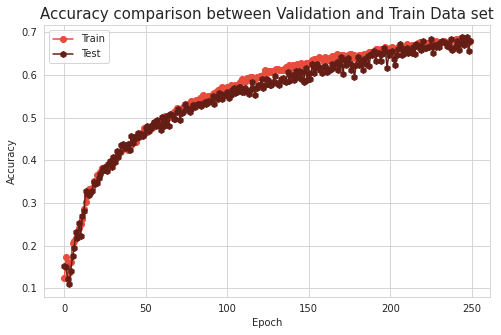

In [30]:
acc_plot(history)

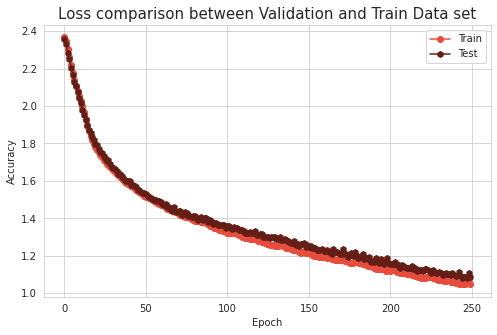

In [31]:
loss_plot(history)

In [32]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [33]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[138,   0,   3,   2,   3,   9,   2,  18,   4,  25],
       [  1,  45,  10,   4,   3,   0,   1,   6,   2,   7],
       [ 20,   0,  74,  11,   5,  10,   0,  13,  13,  29],
       [  5,   3,  17, 127,   5,   0,   4,   3,  11,   7],
       [ 14,   7,   3,  13, 111,  11,   6,  21,   3,  10],
       [ 45,   0,   5,   0,  11, 128,   2,   8,   3,   1],
       [  1,   0,   0,   6,   0,   1,  71,   2,   0,   0],
       [ 21,   1,   5,   0,   6,   0,   6, 144,   0,   4],
       [  2,   1,   3,   7,   3,   0,   0,   6, 137,  10],
       [ 29,   2,   5,   4,   9,   0,   0,   3,   7, 114]])

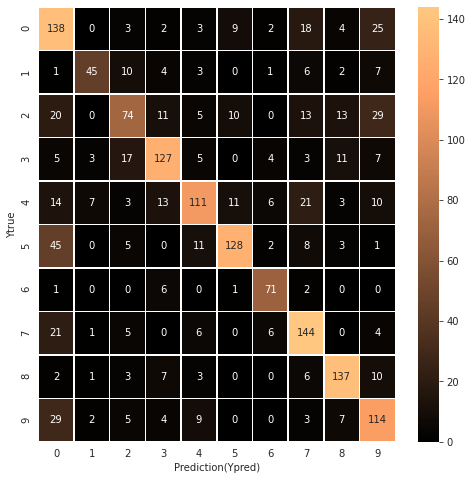

In [34]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

In [35]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,87.654321
8,Siren,81.065089
7,Jackhammer,77.005348
3,Dog bark,69.780220
0,Air Conditioner,67.647059
9,Street Music,65.895954
5,Engine Idling,63.054187
1,Car Horn,56.962025
4,Drilling,55.778894
2,Children Playing,42.285714
